## Mount Google Drive

In [37]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

## Getting started

In [38]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.signal import convolve2d
import os

In [39]:
# show path of current working directory
print(os.getcwd())

# change working directory to /home/karnav/Documents/AM9624/labs/L6
os.chdir('/home/karnav/Documents/AM9624/labs/L6')
print(os.getcwd())

/home/karnav/Documents/AM9624/labs/L6/2025_wk8_hmax
/home/karnav/Documents/AM9624/labs/L6


## Building Gabor filters

In the early 1960s, David Hubel and Torsten Wiesel performed a set of seminal experiments in visual neuroscience. They systematically examined the response properties of neurons in primary visual cortex (V1) in cats and monkeys, and discovered that neurons are tuned to particular spatial locations and orientations across a range of spatial scales. Their discoveries on information processing in the visual system were awarded with a Nobel Prize in 1981. The response functions reported by Hubel and Wiesel can be described well by Gabor filters. Gabor filters are spatially localized, oriented, and bandpass. They form a basis set for sparse coding of natural images, as shown by Olshausen and Field in 1996.

A Gabor filter is defined by the equation:

$$(x, y ; \lambda, \theta, \psi, \sigma, \gamma)=\exp \left(-\frac{x^{\prime 2}+\gamma^2 y^{\prime 2}}{2 \sigma^2}\right) \cos \left(2 \pi \frac{x^{\prime}}{\lambda}+\psi\right)$$

where 

$$x^{\prime}=x \cos \theta+y \sin \theta$$

and 

$$y^{\prime}=-x \sin \theta+y \cos \theta$$

where $\lambda$ is the wavelength of the sinusoid, $\theta$ is the orientation of the filter, $\psi$ is the phase offset of the sinusoid, $\sigma$ is the standard deviation of the Gaussian kernel, and $\gamma$ is the spatial aspect ratio of the Gaussian kernel.

This equation shows that a Gabor filter is a Gaussian kernel modulated by a sinusoidal wave.

### Step 1: Build your own Gabor filters

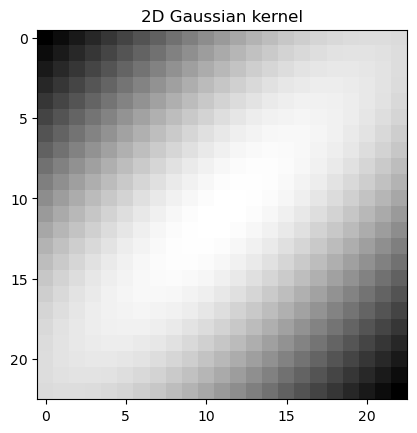

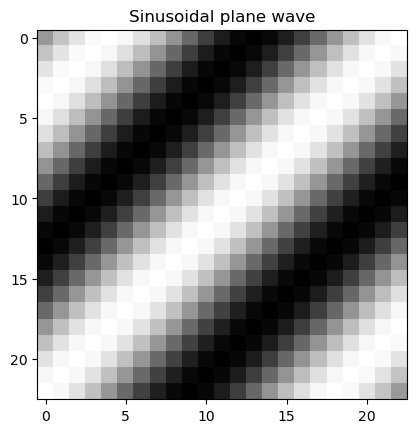

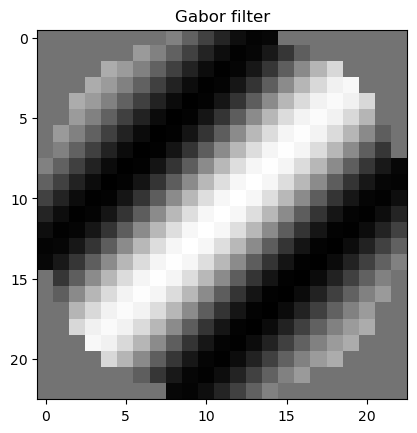

In [40]:
# build gabor filter
def gabor_filter(size, wavelength, orientation, monitor):
    # size = filter size in pixels (w = h)
    # wavelength = wavelength of sinusoid relative to half the size of the filter
    # orientation = desired orientation of filter

    # set parameters (based on neural data from V1)
    lambda_ = size * 2. / wavelength # wavelength of sinusoidal plane wave (how many waves 'fit' in the filter)
    sigma = lambda_ * 0.8 # standard deviation of gaussian kernel
    gamma = 0.3  # spatial aspect ratio of gaussian kernel
    theta = np.deg2rad(orientation + 90) # orientation

    # gaussian
    x, y = np.mgrid[:size, :size] - (size // 2)
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    gauss = np.exp(-(rotx**2 + gamma**2 * roty**2) / (2 * sigma ** 2))

    # sinusoid
    sinusoid = np.cos(2 * np.pi * rotx / lambda_)

    # gabor
    filt = gauss * sinusoid                       # create the gabor filter
    filt[np.sqrt(x**2 + y**2) > (size / 2)] = 0   # set the values outside the circle to 0 (zeroing out edges)
    filt = filt - np.mean(filt)                   # subtract the mean of the filter (normalizing to zero mean)
    filt = filt / np.sqrt(np.sum(filt ** 2))      # normalize energy

    # show
    if monitor:
        plt.figure(); plt.imshow(gauss, cmap=plt.gray()); plt.title('2D Gaussian kernel')
        plt.figure(); plt.imshow(sinusoid, cmap=plt.gray()); plt.title('Sinusoidal plane wave')
        plt.figure(); plt.imshow(filt, cmap=plt.gray()); plt.title('Gabor filter')

    return filt

# generate a filter with the following parameters:
# size = 23, wavelength = 3.6, orientation = -45 degrees
filt = gabor_filter(23, 3.6, -45, 1)

### Step 2: Create a bank of Gabor filters

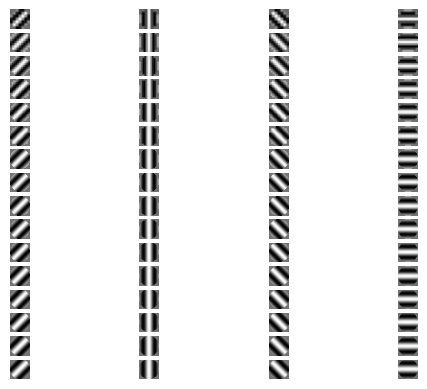

In [41]:
# generate a filter bank
sizes = np.arange(7, 39, 2) # 16 sizes
wavelengths = np.arange(4, 3.2, -0.05) # 16 associated wavelengths
orientations = np.arange(-45, 135, 45) # 4 orientations

# generate the parameters for the filter bank
params = []
i = 0;
for s in sizes:
    i = i + 1
    
    for o in orientations:
        w = wavelengths[i-1]
        params.append((s,w,o))

# create the filter bank
filterBank = []
gaborParams = []
for (size, wavelength, orientation) in params:
    gaborParam = {'size':size, 'wavelength':wavelength, 'orientation':orientation, 'monitor':0}
    filt = gabor_filter(**gaborParam)
    filterBank.append(filt)
    gaborParams.append(gaborParam)

# show filter bank
plt.figure()
n = len(filterBank)
for i in range(n):
    plt.subplot(16,4,i+1)
    plt.axis('off'); plt.imshow(filterBank[i])

## Applying Gabor filters to images

Next, we are going to apply our Gabor filters to the object images from this week's lecture. Download the images and unzip them in Google Drive.

CPU times: user 21.9 ms, sys: 52 µs, total: 21.9 ms
Wall time: 21.9 ms


Text(0.5, 1.0, 'response')

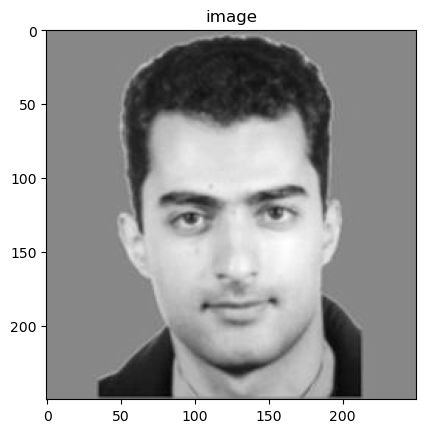

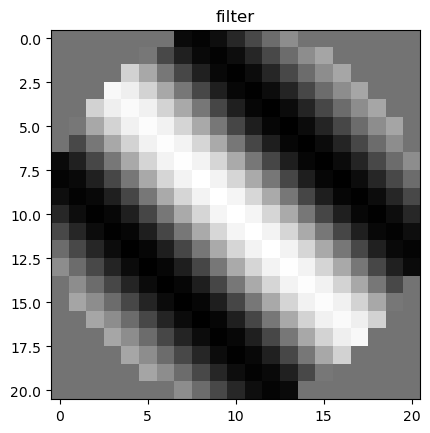

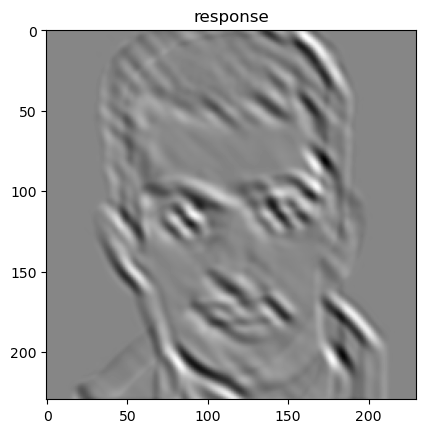

In [42]:
# read in images
# cdir = os.path.abspath(os.getcwd())
pth = '2025_wk8_images'
face = rgb2gray(plt.imread(os.path.join(pth,'image19_66440000_rs.jpg')))
# zebra = rgb2gray(plt.imread(os.path.join(pth,'image32_41110000_rs.jpg')))

# show image and filter
plt.figure(); plt.imshow(face, cmap=plt.gray()); plt.title('image')
filt = filterBank[30]
plt.figure(); plt.imshow(filt, cmap=plt.gray()); plt.title('filter')

# convolve filter with image (convolution = dot product)
%time output = convolve2d(face, filt, mode='valid')
plt.figure(); plt.imshow(output, cmap=plt.gray()); plt.title('response')

Observe that the output after convolution highlights edges and textures that match the frequency and orientation of the Gabor filter. Since the filter you applied has a specific orientation and frequency, it responds most strongly to parts of the zebra's image that contain similar patterns—like its stripes!

That's why you see a high response (bright areas) where the zebra's stripes align with the filter's orientation, and low response (dark areas) elsewhere. This mimics how neurons in V1 detect edges and textures at specific orientations. 

The above is example output for a particular image and filter. Image size is 250 x 250 pixels, filter size is 21 x 21 pixels. To create the output, the filter is convolved with the image, i.e. we move the filter across the image and compute the dot product of the image intensities and the filter at each location.

## The HMAX model: beyond V1

Gabor filters model early stages of visual processing. To extend our model beyond V1, we need to find ways of creating selectivity for increasingly complex shapes as well as invariance to position and scale. The HMAX model implements this extension. The filters in the early stages of HMAX are manually engineered to simulate response properties of neurons in V1 and V2 - as opposed to being learned through experience. Today, we will run HMAX on our images.

![alt text](https://lm2.trinket.io/api/files/67c0b0000688b032000c1639/lab-8-_fig2.png)


The above is a schematic of the HMAX model. During the programming lab, we will focus on the first four layers of HMAX, which roughly capture visual processing from V1 to V4 in the primate visual system. Note that the first layer (S1) is identical to the bank of Gabor filters we created today. Figure adapted from Serre et al. 2007.

Download Python code for HMAX and run it using the code below. The code passes a single example image (image27, snake) through the first four layers of the HMAX model and outputs a pickle file with the image activations, which we will examine in this week's programming assignment.

In [36]:
# import torch library
import torch
from torch.utils.data import DataLoader, Dataset
print("PyTorch Version:", torch.__version__)  # check PyTorch version

# set working directory
hmax_pth = '2025_wk8_hmax'
os.chdir(hmax_pth)

# load image
dataloader = DataLoader('example_images', batch_size = 1)

# compute the response to the image in the first four layers of HMAX
!python example.py

PyTorch Version: 2.5.1


Constructing model
Running model on cuda:0
Saving output of all layers to: output.pkl
[done]
